# Classification of potential high risk patients with lung cancer disease

#### Using microarray data from lung cancer patients in this notebook I'm trying to predict which patients has low life expectacy
* Why modeling cancer mortality?
Lung cancer's a deadly disease (with the highest death rate in the population), having a metric to indicate the potential risk of the patient could be a valuable information for a doctor's decision making.

> Here High risk is defined as the patients who died in a time window of 18 months. 
> In this notebook there'll be no data treatment, as this's already done

Bibliography:


In [1]:
import pandas as pd
import numpy as np
from sklearn import svm, model_selection, metrics, preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
folder='TG/'
df_noq = pd.read_csv(folder+'complete_dataframe.csv')
df_full= df_noq.set_index('Unnamed: 0')
df_feat=df_full[(df_full.ADJUVANT_RT=='No')&(df_full.ADJUVANT_CHEMO=='No')]


In [4]:
genes = df_feat.drop(['MEDIAN_INTENSITY_UNNORMALIZED',
'PCT_ARRAY_OUTLIER',
'PCT_SINGLE_OUTLIER',
'WARNING',
'LABORATORY_BATCH','High_risk',
'Histologic grade','VITAL_STATUS', 'FIRST_PROGRESSION_OR_RELAPSE', 'MONTHS_TO_FIRST_PROGRESSION', 'MTHS_TO_LAST_CLINICAL_ASSESSMENT', 'MONTHS_TO_LAST_CONTACT_OR_DEATH', 'SMOKING_HISTORY', 'SURGICAL_MARGINS','SITE','TESTTYPE', 'IN_DC_STUDY','RACE','AGE_AT_DIAGNOSIS','ADJUVANT_CHEMO', 'ADJUVANT_RT', 'PATHOLOGIC_N_STAGE', 'PATHOLOGIC_T_STAGE','BlindedIDs', 'PATIENT_ID', 'Stratagene', 'DC_STUDY_ID','target','GENDER'],axis=1).copy()

# Data visualization

In [5]:
x=df_full.drop(['MEDIAN_INTENSITY_UNNORMALIZED',
'PCT_ARRAY_OUTLIER',
'PCT_SINGLE_OUTLIER',
'WARNING',
'LABORATORY_BATCH',
'Histologic grade','VITAL_STATUS', 'FIRST_PROGRESSION_OR_RELAPSE', 'MONTHS_TO_FIRST_PROGRESSION', 'MTHS_TO_LAST_CLINICAL_ASSESSMENT', 'MONTHS_TO_LAST_CONTACT_OR_DEATH', 'SMOKING_HISTORY', 'SURGICAL_MARGINS',
'High_risk','SITE','TESTTYPE', 'IN_DC_STUDY','RACE','BlindedIDs', 'PATIENT_ID', 'Stratagene', 'DC_STUDY_ID','target','GENDER'],axis=1).copy()
genes = df_feat.drop(['MEDIAN_INTENSITY_UNNORMALIZED',
'PCT_ARRAY_OUTLIER',
'PCT_SINGLE_OUTLIER',
'WARNING',
'LABORATORY_BATCH',
'Histologic grade','VITAL_STATUS', 'FIRST_PROGRESSION_OR_RELAPSE', 'MONTHS_TO_FIRST_PROGRESSION', 'MTHS_TO_LAST_CLINICAL_ASSESSMENT', 'MONTHS_TO_LAST_CONTACT_OR_DEATH', 'SMOKING_HISTORY', 'SURGICAL_MARGINS',
'High_risk','SITE','TESTTYPE', 'IN_DC_STUDY','RACE','AGE_AT_DIAGNOSIS','ADJUVANT_CHEMO', 'ADJUVANT_RT', 'PATHOLOGIC_N_STAGE', 'PATHOLOGIC_T_STAGE','BlindedIDs', 'PATIENT_ID', 'Stratagene', 'DC_STUDY_ID','target','GENDER'],axis=1).copy()
y = df_feat['High_risk']

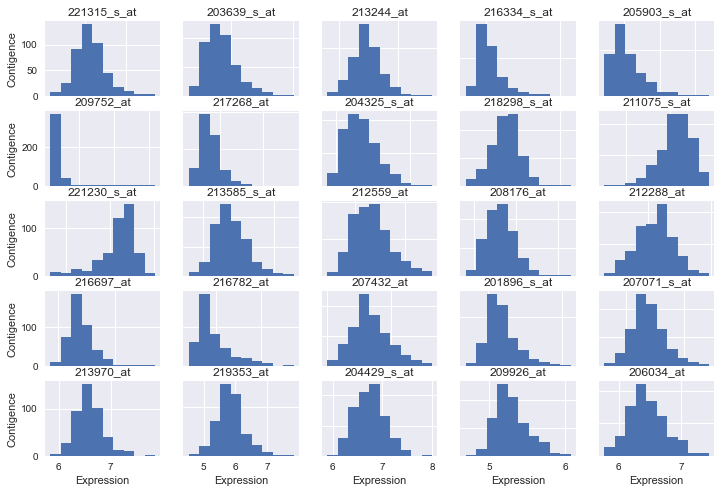

In [6]:
plt.style.use('seaborn')
fig, axs = plt.subplots(5, 5, figsize=(12, 8))
for i in range(0,5):
    for j in range(0,5):
        gene_choice=np.random.choice(range(genes.shape[1]))
        gene_data=df_full.iloc[:,gene_choice]
        axs[i, j].hist(gene_data)
        axs[i, j].set_title('{}'.format(gene_data.name))
        
for ax in axs.flat:
    ax.set(xlabel='Expression', ylabel='Contigence')
    
for ax in axs.flat:
    ax.label_outer()

### The data was already treated using microarray cDNA proper techniques.
Here we need to reduce the number of dimensions, from 22k for only a little more than 300 samples! First we'll identify genes which differ from high risk patients and low risk patients, for this we'll do a oneway ANOVA

In [7]:
high_risk = (df_feat.High_risk==1)
low_risk = (df_feat.High_risk==0)
oneway={}
oneway['stat']={}
oneway['p_val']={}
for gene in genes.columns:
    stats, p_val = f_oneway(df_feat[high_risk][gene],df_feat[low_risk][gene])
    oneway['stat'][gene]=stats
    oneway['p_val'][gene]=p_val

In [30]:
anova_df=pd.DataFrame(oneway)

In [48]:
genes_p005=list(anova_df[anova_df.p_val<0.05].index) 
#p_value<0.05 is the standard for clinical trials to assure that are significant statistical difference 
#between treatments so we'll stick to this values this

In [50]:
df_g=df_full[genes_p005]
y=df_full.High_risk

In [51]:
genes_diff = df_g - df_g.mean()
genes_norm = genes_diff/df_g.std()

In [53]:
genes_norm.shape

(442, 1206)

## We still have 1206 genes, so we have to reduce even more our dimensionality!
> One popular alghoritm to that is PCA which projects our data to a smaller space by using the eigenvectors of our covariance matrix! However we have to choose the number of components vectors we're using

Text(0.5, 1.0, 'Cummulative explained variance of Principal Components')

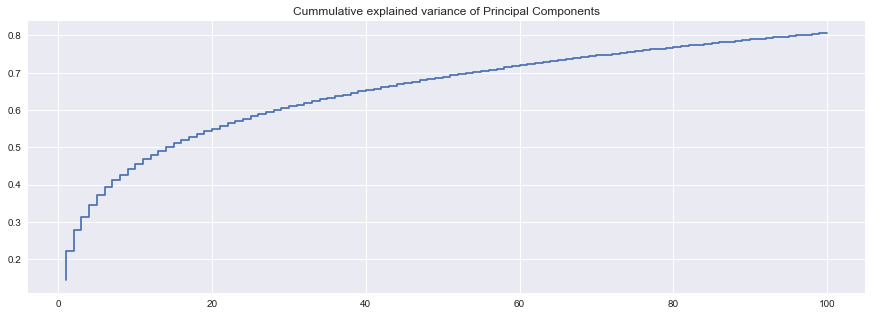

In [55]:
plt.style.use('seaborn')
pca_model = PCA(random_state=42).fit(genes_norm)
%matplotlib inline
variances_explained = pca_model.explained_variance_ratio_.cumsum()
plt.figure(figsize=(15,5))
plt.step(list(range(1,100+1)),variances_explained[:100])
plt.title("Cummulative explained variance of Principal Components")

# The most popular alghoritm for high dimensions and genes classification is the Support Vector Component 

* Now what we want to do is to start modeling heads on, however there are many parameters to optimize and GridSearchCV in a little sample with SVC can be really slow. 
* So for this problem one solution would be to use Bayesian Optimization. Using hyperopt for this sake

# SVC - Vanilla testing
>We're fixing the C=1, this is the default parameter for SVC library

In [57]:
def skl_roc_get(model, vec_train, vec_test):
    model.fit(x_train, y_train)
    tr_score=model.predict(x_train)
    te_score=model.predict(x_test)
    vec_train.append(metrics.roc_auc_score(y_train, tr_score))
    vec_test.append(metrics.roc_auc_score(y_test, te_score))
    

In [78]:
step=[]
roc_train_linear=[]
roc_test_linear=[]
roc_train_poly=[]
roc_test_poly=[]
roc_train_rbf=[]
roc_test_rbf=[]

dummy_tr=[]
dummy_te=[]
for i in range(1, 50):
    step.append(i)
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        genes_norm, y, test_size=0.3, random_state=42)
    pca_model = PCA(n_components=i, random_state=42)
    x_train=pca_model.fit_transform(x_train)
    x_test=pca_model.transform(x_test)
    skl_roc_get(svm.SVC(C=1,kernel='linear'), roc_train_linear, roc_test_linear)
    skl_roc_get(svm.SVC(C=1,kernel='poly'), roc_train_poly, roc_test_poly)
    skl_roc_get(svm.SVC(C=1,kernel='rbf'), roc_train_rbf, roc_test_rbf)
    
    dummy_te.append(metrics.roc_auc_score(y_test, np.zeros(y_test.shape)))
    dummy_tr.append(metrics.roc_auc_score(y_train, np.zeros(y_train.shape)))
    

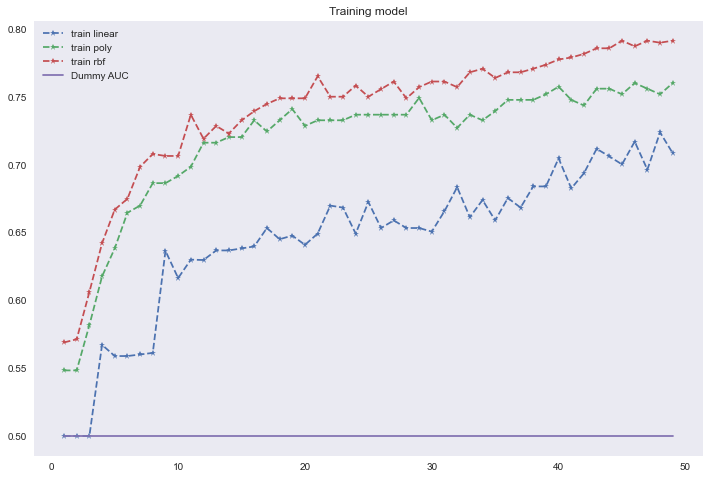

In [81]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(step, roc_train_linear, '--*',label='train linear')
plt.plot(step, roc_train_poly, '--*',label='train poly')
plt.plot(step, roc_train_rbf, '--*',label='train rbf')
plt.title('Training model')
plt.plot(step, dummy_tr,label='Dummy AUC')
plt.grid()
plt.legend()

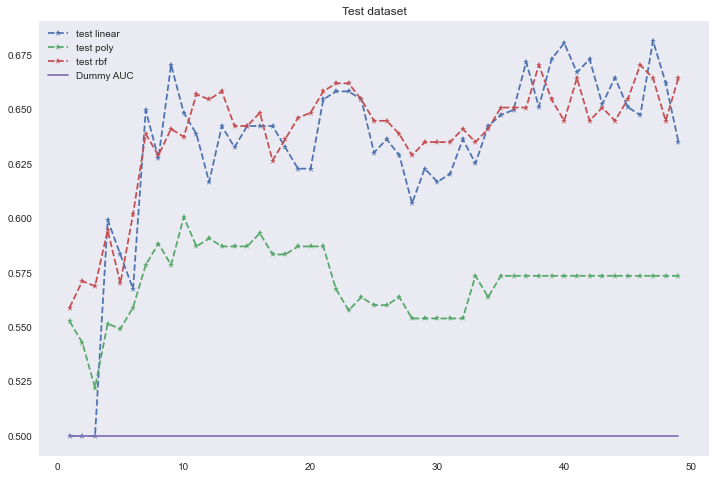

In [82]:
plt.figure(figsize=(12,8))
plt.plot(step, roc_test_linear, '--*',label='test linear')
plt.plot(step, roc_test_poly, '--*',label='test poly')
plt.plot(step, roc_test_rbf, '--*',label='test rbf')
plt.title('Test dataset')

plt.plot(step, dummy_te,label='Dummy AUC')
plt.grid()
plt.legend()


# SVC - Optimizing
* The vanilla fit showed us many interesting things:
>1. RBF and POLY has a better fit on the train set but they overfit the data tremendously fast!
>2. Linear kernel had the best behaviour: it overfits only for high dimensions and for most ocasions had the best performance in the test set.
* Now we want to optimize our model, but SVC can be quite expensive to optmize 
* Using the anchor point method we could try to fix 15.
* We'll use hyperopt library to optimize variables from the model fit!

In [143]:
from hyperopt import hp, tpe, Trials, STATUS_OK, fmin
from sklearn.model_selection import cross_val_score


In [214]:
param_hyperopt= {
    'SVC':{
        'C': hp.uniform('C', 0, 100),
        'gamma':hp.uniform('gamma', -1, 10),
        'kernel': hp.choice('kernel', ['linear', 'rbf'])
    },
    'PCA':{ 
        'n_components': hp.choice('n_components', [x for x in range(5, 30)])}
}


In [215]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
        genes_norm, y, test_size=0.3, random_state=42)

def roc_auc(estimator, X, y):
    y_pred=estimator.predict(X)
    return metrics.roc_auc_score(y, y_pred)
    

def objective_function(params):
    svc_p, pca_p = params['SVC'], params['PCA']
    svc = svm.SVC(**svc_p)
    pca_model = PCA(**pca_p)
    x_pca=pca_model.fit_transform(x_train)
    score = cross_val_score(svc, x_pca, y_train, cv=5, scoring=roc_auc).mean()
    return {'loss': -score, 'status': STATUS_OK}

In [216]:
trials = Trials()
best_param = fmin(objective_function, 
                      param_hyperopt, 
                      algo=tpe.suggest, 
                      max_evals=100, 
                      trials=trials,
                      rstate= np.random.RandomState(42))


100%|██████████| 100/100 [41:19<00:00, 24.79s/trial, best loss: -0.6252847321005216] 


In [217]:
loss = [x['result']['loss'] for x in trials.trials]


In [223]:
best_param

{'C': 69.65088831573054,
 'gamma': 4.86641994953721,
 'kernel': 0,
 'n_components': 7}

In [224]:
svc = svm.SVC(C=69.65088831573054, kernel='linear')


In [225]:
pca_model = PCA(n_components=[x for x in range(5, 30)][7])
x_pca=pca_model.fit_transform(x_train)
svc.fit(x_pca, y_train)

SVC(C=69.65088831573054, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=4.86641994953721,
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [226]:
tr_score=svc.predict(x_pca)
x_t_pca = pca_model.transform(x_test)
te_score=svc.predict(x_t_pca)

In [227]:
print(metrics.roc_auc_score(y_train, tr_score))
print(metrics.roc_auc_score(y_test, te_score))

0.6283409530508176
0.6168101386896222


> Althrough we used a optimizing alghoritm we can see clearly that at the first first graph we can reach almost a 0.675 ROC while after optimization we barely get 0.62 there's also another incosistency which is using a gamma value with a linear kernel, however the optimization process is another evidence that linear kernel is probably the best for this problem. So now we'll change C and n_components parameters to optimize our function

In [255]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
            genes_norm, y, test_size=0.3, random_state=42)

PCA_range=[x for x in range(10, 41, 2)]
C_range=[x for x in range(1, 100, 4)]
auc_train = np.zeros((len(C_range), len(PCA_range)))
auc_test = np.zeros((len(C_range), len(PCA_range)))


for i in range(0, len(C_range)):
    for j in range(0, len(PCA_range)):
        c= C_range[i]
        p= PCA_range[j]
        
        pca_model = PCA(n_components=p)
        x_tr_pca=pca_model.fit_transform(x_train)
        x_te_pca=pca_model.transform(x_test)
        
        svc_model=svm.SVC(C=c,kernel='linear')
        svc_model.fit(x_tr_pca, y_train)
        
        auc_train[i, j] = roc_auc(svc_model, x_tr_pca, y_train)
        auc_test[i, j] = roc_auc(svc_model, x_te_pca, y_test)

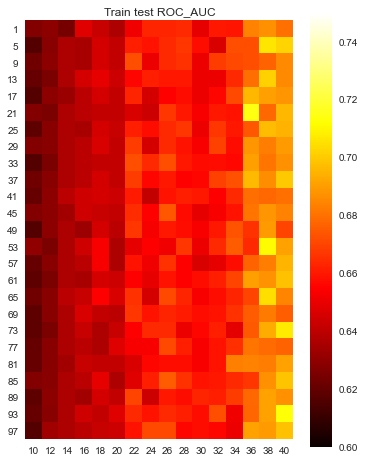

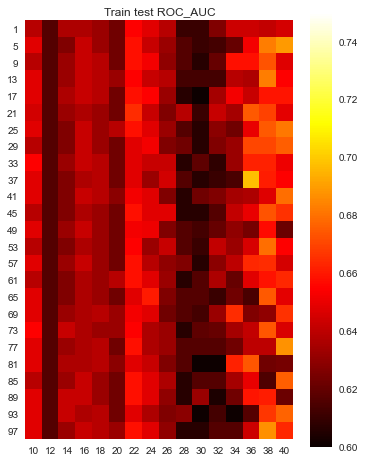

In [325]:
plt.figure(figsize=(6, 8))
plt.imshow(auc_train,cmap='hot', vmin=0.6, vmax=0.75)
plt.colorbar()
plt.xticks(ticks=[i for i in range(0, len(PCA_range))], labels=PCA_range)
plt.yticks(ticks=[i for i in range(0, len(C_range))], labels=C_range)
plt.title('Train test ROC_AUC')

plt.rcParams["axes.grid"] = False

plt.figure(figsize=(6, 8))
plt.imshow(auc_test,cmap='hot', vmin=0.6, vmax=0.75)
plt.title('Train test ROC_AUC')

plt.colorbar()
plt.xticks(ticks=[i for i in range(0, len(PCA_range))], labels=PCA_range)
plt.yticks(ticks=[i for i in range(0, len(C_range))], labels=C_range)

plt.rcParams["axes.grid"] = False

In [326]:
svc = svm.SVC(C=37, kernel='linear')
pca_model = PCA(36)
x_pca=pca_model.fit_transform(x_train)
svc.fit(x_pca, y_train)

SVC(C=37, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [327]:
tr_score=svc.predict(x_pca)
x_t_pca = pca_model.transform(x_test)
te_score=svc.predict(x_t_pca)

In [328]:
print(metrics.roc_auc_score(y_train, tr_score))
print(metrics.roc_auc_score(y_test, te_score))

0.6728943203798137
0.6743185078909613


In [329]:
print(metrics.accuracy_score(y_train, tr_score))
print(metrics.accuracy_score(y_test, te_score))

0.7184466019417476
0.7218045112781954


# Conclusion
> We showed that was possible to optimize the parameters to get a better solution
> This problem was especially hard because we had really small subset of samples with a gigantic number of dimensionality